## Introduction

The `bfcr` package provides functions to perform nonparametric Bayesian inference for covariate-adjusted covariance operators with functional response data as described in "Bayesian functional covariance regression" by Shamshoian et al. (2021). This package contains a C++ implementation of the Markov-Chain Monte-Carlo sampling algorithm in the Supporting Information document and several convenience functions for extracting posterior summaries. The online GitHub repository contains all code used in the analysis of the resting state EEG data from children with autism spectrum disorder as well as the sleep waveforms collected on patients' polysomnography from SHHS visit 1. However, both of these data sets are not publicly available so we illustrate our methods with a simulated example.

## Installation 

Simply install with GitHub by using the R package `devtools`.

In [10]:
if (!requireNamespace("devtools", quietly = TRUE)) {
    install.packages("devtools")
  }
suppressMessages(devtools::install_github("jshamsho/bfcr"))
library(bfcr)

## Background info

With the exception of some recent contributions, most functional regression frameworks operate under the assumption of that covariate information does not affect patterns of covariation. The methods in this repository address this disparity providing full nonparametric Bayesian inference on key scientific objects of interest. We assume $N$ response curves are observed with the $i$th response curve having covariate-adjusted mean $\mu(t, x_{i})$, random deviation $r_{i}(t, x_{i})$, and random measurement source error $\epsilon_{i}(t)$. Critically, this framework allows the random component $r_{i}(t, x_{i})$ to systematically vary across scalar covariates $x_{i}$, which induces covariate-adjusted patterns of covariation. The data generating model is 

\begin{gather*}
y_{i}(t) \sim \mu(t, x_{i}) + r_{i}(t, x_{i}) + \epsilon_{i}(t),\,\, \epsilon_{i}(t)\sim N(0, \varphi^{2})\\
r_{i}(t, x_{i}) = \sum_{j=1}^{k}\psi_{j}(t, x_{i})\eta_{ij}, \,\,\eta_{ij}\sim N(0, 1)\\
\mu(t, x_{i}) = \sum_{r=1}^{R}f_{r}(t, x_{i}),\,\,\psi_{j}(t) = \sum_{r=1}^{R}l_{rj}(t, x_{i})
\end{gather*}

Here $f_{r}(t, x_{i})$ and $l_{rj}(t, x_{i})$ are general smooth functions which are in practice estimated via basis expansion. Note that the conditional mean function $\mathbb{E}[y_{i}(t)] = \mu(t, x_{i})$ and the conditional within-subject covariance function is $\text{Cov}[y_{i}(t), y_{i}(t')] = \sum_{j=1}^{k}\psi_{j}(t,x_{i})\psi_{j}(t', x_{i}) + \varphi^{2}\delta_{tt'}$. Estimation on all unknown components is carried out in a Bayesian manner providing full posterior inference. Please see our manuscript for more details on specifying the form of smooth functions, priors, and computation.

## Example

This example will simulate a data set with $N = 100$ response curves and one covariate so that $x_{i}$ is a scalar.

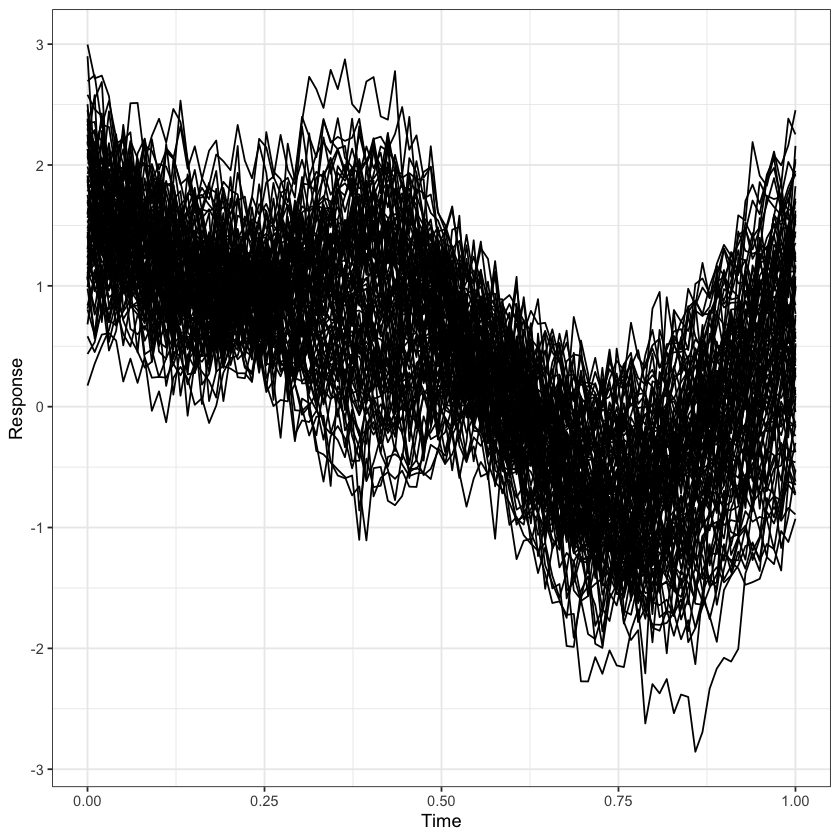

In [8]:
suppressMessages(library(bfcr))
suppressMessages(library(mgcv))
suppressMessages(library(tidyverse))
set.seed(999)

# Change this to your local directory
file_name <- paste0("/Users/johnshamshoian/Documents/R_projects/bfcr/",
                    "Simulations/Simulation_parameters.RData")
load(file_name)

n <- 100
k <- simparam$k
times <- simparam$times # Time grid
beta <- simparam$beta
lambda <- simparam$lambda
time_basis <- simparam$time_basis
x <- seq(from = 0, to = 1, length.out = n) # Covariate grid
df_x <- simparam$df_x
x_basis <- smoothCon(s(x, k = df_x, m = 2, bs = "ps"), data.frame(x),
                     absorb.cons = TRUE)
df_times <- simparam$df_times
x_basis_fit <- smoothCon(s(x, k = df_x + 2, m = 2, bs = "ps"),
                         absorb.cons = TRUE, data.frame(x))
time_basis_fit <- smoothCon(s(times, k = df_times, m = 2, bs = "ps"),
                            data.frame(times))
design_mean <- cbind(1, x_basis_fit[[1]]$X)
indices_mean <- c(1, 2, 2)
time_penalty <- time_basis_fit[[1]]$S.scale * time_basis[[1]]$S[[1]]
x_penalty <- x_basis_fit[[1]]$S.scale * x_basis_fit[[1]]$S[[1]]
S_list <- list(x_penalty, time_penalty)
S <- tensor.prod.penalties(S_list)
penalties_mean <- list(time_penalty, S[[1]], S[[2]])
k_fit <- k + 2
evaluate_basis <- function(x_basis, x) {
  c(1, PredictMat(x_basis, data.frame(x)))
}
design_mean_truth <- cbind(1, x_basis[[1]]$X)

lambda_truth <- lambda
design_var_truth <- cbind(1, x_basis[[1]]$X)
design_var <- cbind(1, x_basis_fit[[1]]$X)
evaluate_basis_var <- function(x_basis, x) {
  c(1, PredictMat(x_basis, data.frame(x)))
}
evaluate_basis_var_truth <- function(x_basis, x) {
  c(1, PredictMat(x_basis, data.frame(x)))
}
penalties_var <- list(time_penalty, S[[1]], S[[2]])
indices_var <- c(1, 2, 2)

# Generate random data
eta <- rnorm(n * k) %>% array(dim = c(n, k))
Y <- time_basis[[1]]$X %*% beta %*% t(design_mean_truth) %>% t()
for (kp in 1:k) {
  Y <- Y + time_basis[[1]]$X %*% lambda_truth[,,kp] %*% 
    t(design_var_truth) %*% diag(eta[,kp]) %>% t()
}
Y_errors <- Y + rnorm(n * length(times), sd = .20) %>% matrix(n, length(times))

# Visualize data
data_tibble <- tibble(y = c(t(Y_errors)), time = rep(times, n), ID = rep(1:n, each = length(times)))
data_tibble %>%
  ggplot(aes(time, y, group = ID)) +
  geom_line() +
  labs(x = "Time", y = "Response") +
  theme_bw()

In [9]:
mcmc_results <- run_mcmc(Y_errors, design_mean,
                         design_var, time_basis_fit[[1]]$X,
                         times, penalties_mean, penalties_var,
                         indices_mean, indices_var, k_fit, 10000, 5000, 5, "pooled")

In [31]:
bfcr::run_mcmc()

ERROR: Error in bfcr::run_mcmc(): object '_bfcr_run_mcmc' not found
